### Introduction to Citation Trends Analysis

The analysis investigates citation patterns over time, focusing on the evolving dynamics in academic publishing. Using the OpenCitations Meta dataset, the study explores trends in the accumulation of citations across various academic fields from 2000 to 2020. This research aims to uncover whether citation behaviors have changed significantly, examining factors such as the total volume of citations and the speed at which they are accumulated (RAGS). The study employs techniques like cumulative distribution functions (CDF) and probability mass functions (PMF) to provide a comprehensive view of the data.

The goal is to determine how citations have evolved, particularly in light of the rapid growth in publications, to assess whether a potential slowdown in citation speed indicates saturation in the academic landscape. This introduction sets the stage for detailed visualizations and insights derived from the dataset, aiming to provide clarity on long-term citation trends.

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as spark_sum, col, lit, row_number, count, desc, input_file_name, regexp_extract, lag, mean, percent_rank
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

spark = SparkSession.builder \
    .appName("Authors Citation Analysis") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.initialExecutors", "2") \
    .config("spark.dynamicAllocation.minExecutors", "1") \
    .config("spark.dynamicAllocation.maxExecutors", "10") \
    .config("spark.driver.maxResultSize", "3g") \
    .getOrCreate()

In [90]:
# Set the base directory where the author-year folders are located
base_dir = "/share/smartdata/citations/UPDATED_authors_count"

# Define the range of years you are interested in
start_year = 2000
end_year = 2020

# Create an empty DataFrame to accumulate the data
citation_df = None

# Loop through each year and process the corresponding folder
for year in range(start_year, end_year + 1):
    folder_path = f"{base_dir}/author-year={year}"
    
    # Read all CSV files in the folder
    df = spark.read.csv(folder_path, header=True, inferSchema=True)
    
    # Add a year column to the DataFrame
    df = df.withColumn("year", lit(year))
    
    # Accumulate the data
    if citation_df is None:
        citation_df = df
    else:
        citation_df = citation_df.union(df)

# Group by year and sum the citation counts for each year
yearly_citations = citation_df.groupBy("year").agg(spark_sum("citation_count").alias("total_citations"))

# Convert to Pandas DataFrame for easier plotting
yearly_citations_pd = yearly_citations.orderBy("year").toPandas()

# Calculate the total number of citations across all years
total_citations = yearly_citations_pd['total_citations'].sum()

# Calculate the normalized CDF (values between 0 and 1)
yearly_citations_pd['cdf'] = yearly_citations_pd['total_citations'].cumsum() / total_citations

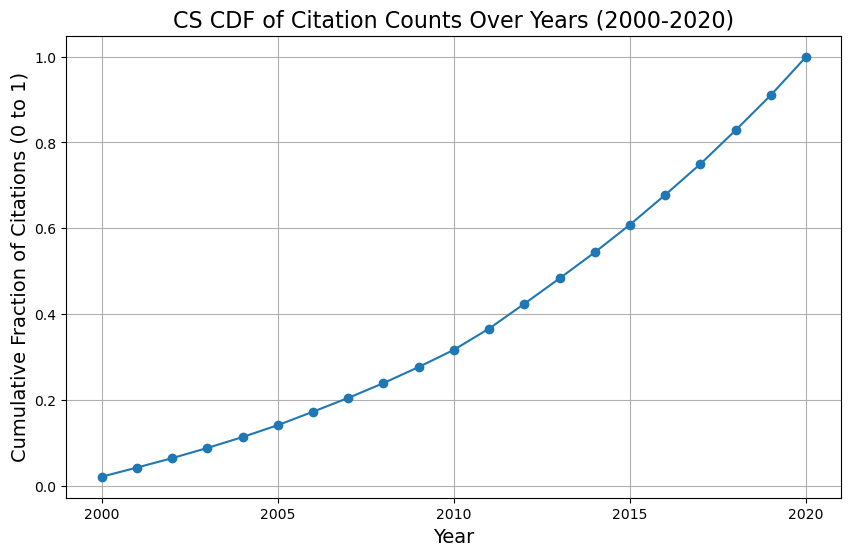

In [96]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(yearly_citations_pd['year'], yearly_citations_pd['cdf'], marker='o')
plt.title("CS CDF of Citation Counts Over Years (2000-2020)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Cumulative Fraction of Citations (0 to 1)", fontsize=14)
plt.grid(True)

# Set x-ticks to display every 5 years
plt.xticks(np.arange(start_year, end_year + 1, step=5))  # Adjust step to 5 for spacing

plt.savefig('filtered/normCDF.png')
plt.show()


### Standard deviation analysis
Perform Aggregation and Analysis
Now, let's calculate the total number of citations, average citations per author, and standard deviation for both years.

In [14]:
# Load CSV files for 2010
df_2010 = spark.read.csv("/share/smartdata/citations/UPDATED_authors_count/author-year=2010/*.csv", header=True, inferSchema=True)

# Load CSV files for 2020
df_2020 = spark.read.csv("/share/smartdata/citations/UPDATED_authors_count/author-year=2020/*.csv", header=True, inferSchema=True)

from pyspark.sql import functions as F

# Calculate total citations for 2010
total_citations_2010 = df_2010.agg(F.sum("citation_count").alias("total_citations")).collect()[0]["total_citations"]

# Calculate average citations per author for 2010
avg_citations_2010 = df_2010.agg(F.avg("citation_count").alias("avg_citations")).collect()[0]["avg_citations"]

# Calculate standard deviation for 2010
stddev_citations_2010 = df_2010.agg(F.stddev("citation_count").alias("stddev_citations")).collect()[0]["stddev_citations"]

# Calculate total citations for 2020
total_citations_2020 = df_2020.agg(F.sum("citation_count").alias("total_citations")).collect()[0]["total_citations"]

# Calculate average citations per author for 2020
avg_citations_2020 = df_2020.agg(F.avg("citation_count").alias("avg_citations")).collect()[0]["avg_citations"]

# Calculate standard deviation for 2020
stddev_citations_2020 = df_2020.agg(F.stddev("citation_count").alias("stddev_citations")).collect()[0]["stddev_citations"]


In [15]:
print(f"Total Citations in 2010: {total_citations_2010}")
print(f"Average Citations per Author in 2010: {avg_citations_2010}")
print(f"Standard Deviation of Citations in 2010: {stddev_citations_2010}")

print(f"Total Citations in 2020: {total_citations_2020}")
print(f"Average Citations per Author in 2020: {avg_citations_2020}")
print(f"Standard Deviation of Citations in 2020: {stddev_citations_2020}")


Total Citations in 2010: 2699101
Average Citations per Author in 2010: 1.1173731990327778
Standard Deviation of Citations in 2010: 0.8703445359864429
Total Citations in 2020: 6007560
Average Citations per Author in 2020: 1.1514300877608086
Standard Deviation of Citations in 2020: 1.0817342856688186


### Grafici con analisi statistiche: PMF -> 2000-2020

In [123]:
# Definisci il percorso base ai dati
base_path = "/share/smartdata/citations/UPDATED_authors_count"

# Leggi i dati da tutte le sottocartelle e aggiungi il nome del file come colonna
df = spark.read.csv(f"{base_path}/author-year=*/*.csv", header=True, inferSchema=True) \
    .withColumn("filename", input_file_name())

# Estrai l'anno dal nome del file e aggiungi come colonna 'year'
df = df.withColumn("year", regexp_extract("filename", "author-year=(\\d{4})", 1).cast('int'))

# Filtra i dati per includere solo gli anni dal 2010 al 2020
filtered_df = df.filter((col("year") >= 2000) & (col("year") <= 2020))

# Aggrega per conteggio di citazioni e calcola la frequenza
pmf_df = filtered_df.groupBy("citation_count").count()

# Calcola il totale di autori per normalizzare la PMF
total_authors = pmf_df.groupBy().sum("count").collect()[0][0]

# Aggiungi una colonna PMF calcolata come frequenza diviso il totale degli autori
pmf_df = pmf_df.withColumn("pmf", col("count") / total_authors)

# Ordina i risultati per citation_count in ordine crescente
pmf_df = pmf_df.orderBy("citation_count")

# Mostra il risultato
pmf_df.show()

+--------------+--------+--------------------+
|citation_count|   count|                 pmf|
+--------------+--------+--------------------+
|             1|57449627|  0.9546148875758782|
|             2| 1348757| 0.02241169489093774|
|             3|  587807|0.009767327353079495|
|             4|  298478|0.004959676107451019|
|             5|  167184|0.002778022133450...|
|             6|   99963|0.001661040688858...|
|             7|   63338|0.001052459361472982|
|             8|   41674|6.924783136509685E-4|
|             9|   28546|4.743361794279538...|
|            10|   20263|3.367012542474822...|
|            11|   14770|2.454265175559055E-4|
|            12|   10897|1.810705999869128E-4|
|            13|    9784|1.625763742563967E-4|
|            14|    6338|1.053157256783567...|
|            15|    4858|8.072322425772436E-5|
|            16|    3824|6.354170637330958E-5|
|            17|    3075|5.109590666786793E-5|
|            18|    2448|4.067732667412706E-5|
|            

### 2000

In [128]:
# Definisci il percorso base ai dati
base_path = "/share/smartdata/citations/UPDATED_authors_count"

# Leggi i dati da tutte le sottocartelle e aggiungi il nome del file come colonna
df = spark.read.csv(f"{base_path}/author-year=*/*.csv", header=True, inferSchema=True) \
    .withColumn("filename", input_file_name())

# Estrai l'anno dal nome del file e aggiungi come colonna 'year'
df = df.withColumn("year", regexp_extract("filename", "author-year=(\\d{4})", 1).cast('int'))

# Filtra i dati per includere solo gli anni dal 2010 al 2020
filtered_df = df.filter((col("year") == 2000))

# Aggrega per conteggio di citazioni e calcola la frequenza
pmf_df_2000 = filtered_df.groupBy("citation_count").count()

# Calcola il totale di autori per normalizzare la PMF
total_authors = pmf_df_2000.groupBy().sum("count").collect()[0][0]

# Aggiungi una colonna PMF calcolata come frequenza diviso il totale degli autori
pmf_df_2000 = pmf_df_2000.withColumn("pmf", col("count") / total_authors)

# Ordina i risultati per citation_count in ordine crescente
pmf_df_2000 = pmf_df_2000.orderBy("citation_count")

# Mostra il risultato
pmf_df_2000.show()

+--------------+-------+--------------------+
|citation_count|  count|                 pmf|
+--------------+-------+--------------------+
|             1|1300696|  0.9795585157537925|
|             2|  14931|0.011244586128288143|
|             3|   5668|0.004268589791382841|
|             4|   2818|0.002122245242081...|
|             5|   1414|0.001064888137793...|
|             6|    842|6.341130212322428E-4|
|             7|    463|3.486868513426703E-4|
|             8|    302|2.274372118908994...|
|             9|    199|1.498675667757913...|
|            10|    119|8.961929872522196E-5|
|            11|     89|6.702619820625845E-5|
|            12|     71|5.347033789488033E-5|
|            13|     49|3.690206418097375E-5|
|            14|     35|2.635861727212410...|
|            15|     25|1.882758376580293...|
|            16|     15|1.129655025948176E-5|
|            17|     10|7.531033506321173E-6|
|            18|     25|1.882758376580293...|
|            19|     12|9.03724020

### 2010

In [129]:
# Definisci il percorso base ai dati
base_path = "/share/smartdata/citations/UPDATED_authors_count"

# Leggi i dati da tutte le sottocartelle e aggiungi il nome del file come colonna
df = spark.read.csv(f"{base_path}/author-year=*/*.csv", header=True, inferSchema=True) \
    .withColumn("filename", input_file_name())

# Estrai l'anno dal nome del file e aggiungi come colonna 'year'
df = df.withColumn("year", regexp_extract("filename", "author-year=(\\d{4})", 1).cast('int'))

# Filtra i dati per includere solo gli anni dal 2010 al 2020
filtered_df = df.filter((col("year") == 2010))

# Aggrega per conteggio di citazioni e calcola la frequenza
pmf_df_2010 = filtered_df.groupBy("citation_count").count()

# Calcola il totale di autori per normalizzare la PMF
total_authors = pmf_df_2010.groupBy().sum("count").collect()[0][0]

# Aggiungi una colonna PMF calcolata come frequenza diviso il totale degli autori
pmf_df_2010 = pmf_df_2010.withColumn("pmf", col("count") / total_authors)

# Ordina i risultati per citation_count in ordine crescente
pmf_df_2010 = pmf_df_2010.orderBy("citation_count")

# Mostra il risultato
pmf_df_2010.show()

+--------------+-------+--------------------+
|citation_count|  count|                 pmf|
+--------------+-------+--------------------+
|             1|2308537|  0.9556876059011987|
|             2|  49966|0.020684912962824202|
|             3|  23123| 0.00957245411758764|
|             4|  12287| 0.00508656937866191|
|             5|   7130|0.002951675727993...|
|             6|   4339|0.001796258202491...|
|             7|   2784|0.001152519667143...|
|             8|   1808|7.484754160186158E-4|
|             9|   1337|5.534909464695184E-4|
|            10|    976|4.040442511250935E-4|
|            11|    734|3.038611478748141...|
|            12|    523|2.165114173549425...|
|            13|    360|1.490327155789279...|
|            14|    309|1.279197475385798E-4|
|            15|    231| 9.56293258298121E-5|
|            16|    180|7.451635778946397E-5|
|            17|    129|5.340338974911584...|
|            18|    101|4.181195631519923E-5|
|            19|     85|3.51882800

### 2020

In [130]:
# Definisci il percorso base ai dati
base_path = "/share/smartdata/citations/UPDATED_authors_count"

# Leggi i dati da tutte le sottocartelle e aggiungi il nome del file come colonna
df = spark.read.csv(f"{base_path}/author-year=*/*.csv", header=True, inferSchema=True) \
    .withColumn("filename", input_file_name())

# Estrai l'anno dal nome del file e aggiungi come colonna 'year'
df = df.withColumn("year", regexp_extract("filename", "author-year=(\\d{4})", 1).cast('int'))

# Filtra i dati per includere solo gli anni dal 2010 al 2020
filtered_df = df.filter((col("year") == 2020))

# Aggrega per conteggio di citazioni e calcola la frequenza
pmf_df_2020 = filtered_df.groupBy("citation_count").count()

# Calcola il totale di autori per normalizzare la PMF
total_authors = pmf_df_2020.groupBy().sum("count").collect()[0][0]

# Aggiungi una colonna PMF calcolata come frequenza diviso il totale degli autori
pmf_df_2020 = pmf_df_2020.withColumn("pmf", col("count") / total_authors)

# Ordina i risultati per citation_count in ordine crescente
pmf_df_2020 = pmf_df_2020.orderBy("citation_count")

# Mostra il risultato
pmf_df_2020.show()

+--------------+-------+--------------------+
|citation_count|  count|                 pmf|
+--------------+-------+--------------------+
|             1|4890471|  0.9373248794388552|
|             2| 172790|0.033117539377749056|
|             3|  69119|0.013247590741655402|
|             4|  33126|0.006349045716924099|
|             5|  17933|0.003437101878934972|
|             6|  10088|0.001933501575569...|
|             7|   6234|0.001194830374911092|
|             8|   3974|7.616708228900674E-4|
|             9|   2696|5.167248461277357E-4|
|            10|   1987|3.808354114450337E-4|
|            11|   1541|2.953534821523889...|
|            12|   1096|2.100632163783376...|
|            13|   2423|4.644007055517446...|
|            14|    709| 1.35889434682702E-4|
|            15|    459|8.797355503435855E-5|
|            16|    381| 7.30238005840754E-5|
|            17|    317|6.075733539409948...|
|            18|    303|5.807404613379225...|
|            19|    217|4.15909835

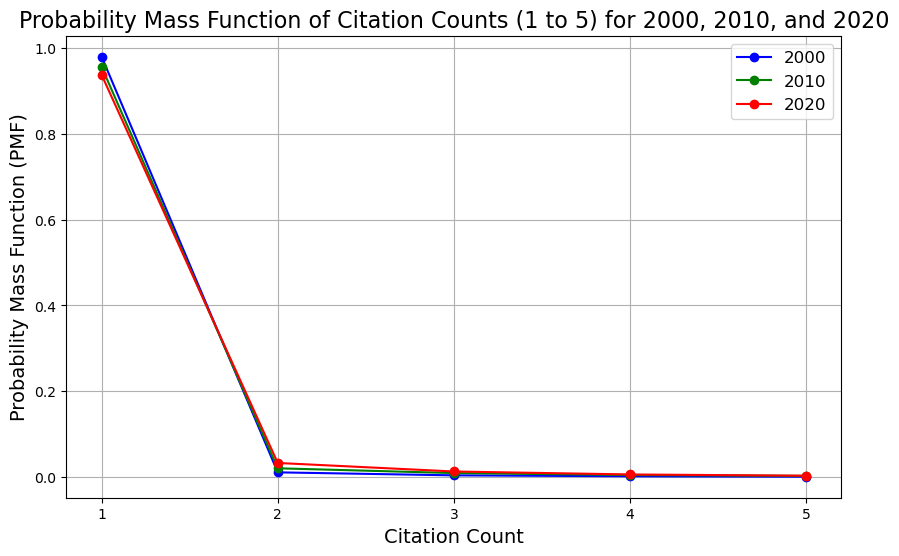

In [136]:
from pyspark.sql.functions import col

# Define the range of citation counts to consider
citation_counts = [1, 2, 3, 4, 5]

# Filter the dataframes for the specified citation counts and collect the 'pmf' data
pmf_2000 = pmf_df_2000.filter(col('citation_count').isin(citation_counts)).select('pmf').rdd.flatMap(lambda x: x).collect()
pmf_2010 = pmf_df_2010.filter(col('citation_count').isin(citation_counts)).select('pmf').rdd.flatMap(lambda x: x).collect()
pmf_2020 = pmf_df_2020.filter(col('citation_count').isin(citation_counts)).select('pmf').rdd.flatMap(lambda x: x).collect()

# Plotting the PMF for each year using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(citation_counts, pmf_2000, marker='o', linestyle='-', color='blue', label='2000')
plt.plot(citation_counts, pmf_2010, marker='o', linestyle='-', color='green', label='2010')
plt.plot(citation_counts, pmf_2020, marker='o', linestyle='-', color='red', label='2020')

plt.title('Probability Mass Function of Citation Counts (1 to 5) for 2000, 2010, and 2020', fontsize = 16)
plt.xlabel('Citation Count', fontsize = 14)
plt.ylabel('Probability Mass Function (PMF)', fontsize = 14)
plt.xticks(citation_counts)  # Ensure x-axis shows every citation count from 1 to 5
plt.legend(fontsize = 12)
plt.grid(True)
plt.savefig("filtered/pmf.png")
plt.show()


## RAGS analysis

In [119]:
from functools import reduce
from pyspark.sql import DataFrame

def read_and_label_data(year):
    path = f"/share/smartdata/citations/UPDATED_authors_count/author-year={year}/*.csv"
    df = spark.read.csv(path, schema="author STRING, citation_count INT")
    return df.withColumn("year", lit(year))  # Using lit() to add the year as a literal column

# List of years to analyze, change as per your interval requirement
years = range(1999,2021)

combined_df = reduce(DataFrame.unionByName, [read_and_label_data(year) for year in years])

# Show the combined DataFrame to verify the results
combined_df.show()

+--------------------+--------------+----+
|              author|citation_count|year|
+--------------------+--------------+----+
|              author|          null|1999|
|Messer, O.E. Bron...|             1|1999|
|Adamski, Jerzy [o...|             1|1999|
|Spencer, Neil S. ...|             1|1999|
|Dennis, T.John [o...|             2|1999|
|Fleming, Andrew N...|             1|1999|
|Chen, G.F. [omid:...|             1|1999|
|Leitner, R [omid:...|             1|1999|
|Eng, M. [omid:ra/...|             1|1999|
|Baldini-Ferroli, ...|             1|1999|
|Z Gil [omid:ra/06...|             1|1999|
|Feng, Ping Yi [om...|             1|1999|
|Stanescu, C. [omi...|             1|1999|
|Casasús, M Pló [o...|             1|1999|
|Zheng, Yuan Zhi [...|             1|1999|
|Shen, Bao-gen [om...|             1|1999|
|Mazumdar, K. [omi...|             1|1999|
|Weilhammer, P. [o...|             1|1999|
|Havlir, Diane [om...|             1|1999|
|Holst, T. [omid:r...|             1|1999|
+----------

In [120]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Define a window spec to partition data by author and order by year
window_spec = Window.partitionBy("author").orderBy("year")

# Calculate RAGS
combined_df = combined_df.withColumn("prev_citations", lag("citation_count").over(window_spec))
combined_df = combined_df.withColumn("RAGS", col("citation_count") - col("prev_citations"))

# Drop rows with no previous year data
combined_df = combined_df.filter(col("RAGS").isNotNull())

# Show results
combined_df.show()


+--------------------+--------------+----+--------------+----+
|              author|citation_count|year|prev_citations|RAGS|
+--------------------+--------------+----+--------------+----+
|"Quan, Jing ""Jim...|             1|2011|             1|   0|
|A Young, Howard [...|             1|2020|             1|   0|
|A. Isabelle, Dian...|             1|2013|             1|   0|
|A. Isabelle, Dian...|             1|2017|             1|   0|
|A. Isabelle, Dian...|             3|2020|             1|   2|
|A. J., Nayana [om...|             1|2019|             1|   0|
|A. J., Nayana [om...|             3|2020|             1|   2|
|A. M. Al-Alwani, ...|             1|2019|             1|   0|
|A. M. Al-Alwani, ...|             2|2020|             1|   1|
|A. Pardo, Sebasti...|             1|2014|             1|   0|
|A. Pardo, Sebasti...|             1|2016|             1|   0|
|A. Pardo, Sebasti...|             1|2018|             1|   0|
|A. Pardo, Sebasti...|             1|2019|             

In [121]:
# Aggregate the data to find the average RAGS per year
rags_summary = combined_df.groupBy("year").agg(avg("RAGS").alias("avg_RAGS")).orderBy("year")

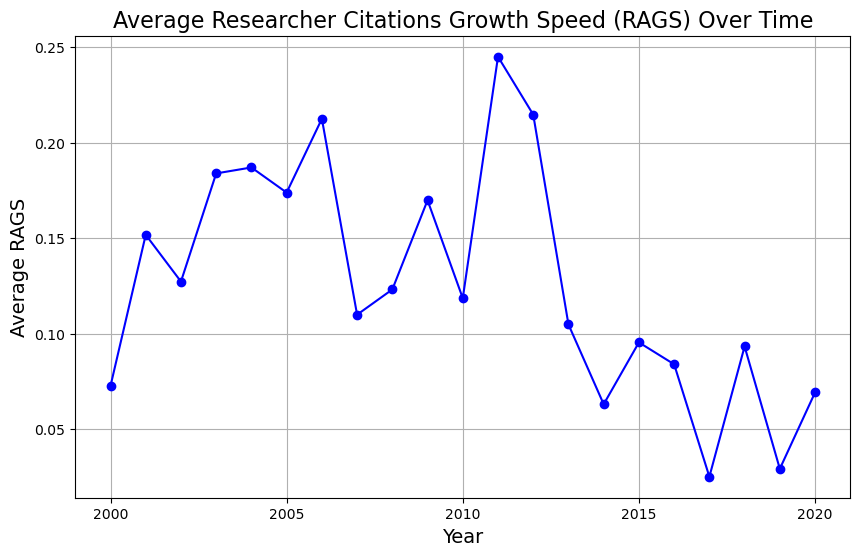

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to Pandas DataFrame for plotting
rags_summary_pd = rags_summary.toPandas()

# Plot the average RAGS over the years
plt.figure(figsize=(10, 6))
plt.plot(rags_summary_pd['year'], rags_summary_pd['avg_RAGS'], marker='o', linestyle='-', color='b')
plt.title('Average Researcher Citations Growth Speed (RAGS) Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average RAGS', fontsize=14)
plt.grid(True)

# Set x-ticks to display every 5 years
plt.xticks(np.arange(min(rags_summary_pd['year']), max(rags_summary_pd['year']) + 1, 5))

plt.savefig("rags2000_2020.png")
plt.show()


In [28]:
# Stop the Spark session
spark.stop()

24/10/02 20:09:05 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
